In [1]:
import numpy as np
import xrft
import matplotlib.pyplot as plt
import os
import xarray as xr

from dask.distributed import Client
# client = Client()
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38403,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:38299,Total threads: 4
Dashboard: /proxy/45491/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:38449,


In [68]:
basepath = "/home/149/ab8992/bottom_near_inertial_waves/revision/RemoveReflections"

e = xr.open_mfdataset(f"{basepath}/archive/output0*/e_10min.nc",decode_times = False).isel(yh = slice(249,251)).mean("yh").e

u = xr.open_mfdataset(f"{basepath}/archive/output0*/u_10min.nc",decode_times = False).isel(yh = slice(249,251)).mean("yh").u

v = xr.open_mfdataset(f"{basepath}/archive/output0*/v_10min.nc",decode_times = False).isel(yq = 250).v


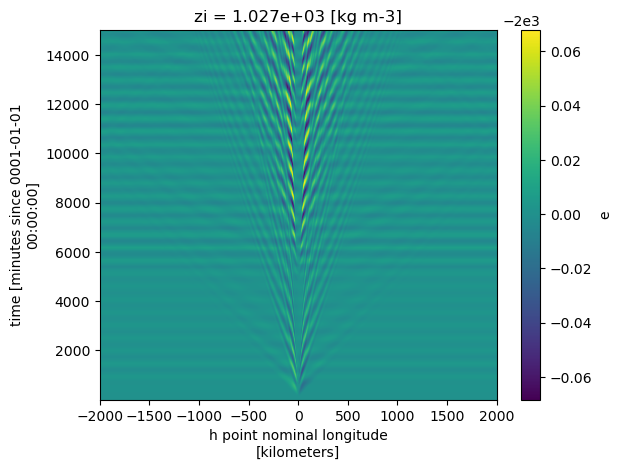

In [47]:
e.isel(zi = 10).plot()

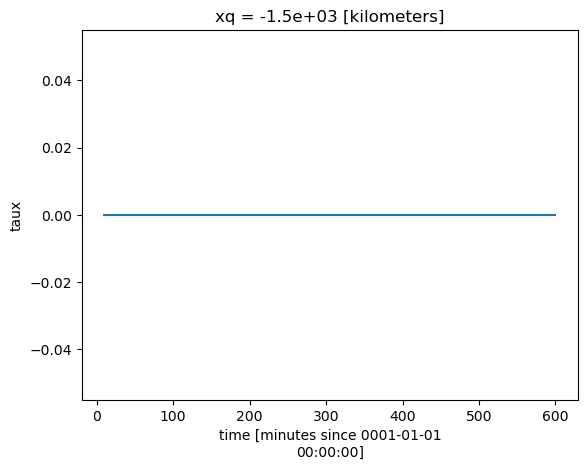

In [27]:
u = xr.open_mfdataset(f"{basepath}/archive/output0*/u_10min.nc",decode_times = False).u
u = xr.open_mfdataset(f"{basepath}/archive/output0*/u_10min.nc",decode_times = False).u
taux = xr.open_mfdataset(f"{basepath}/archive/output000/taux_10min.nc",decode_times = False)

(taux.taux.isel(xq = 250,yh = 249) - taux.taux.isel(xq = 250,yh = 250)).plot()


In [33]:
print(f"True midpoint of forcing: {0.5 * (taux.yh.isel(yh = 249).values + taux.yh.isel(yh = 250).values)}")

True midpoint of forcing: -1500.0


In [38]:
v.yq


<xarray.DataArray 'yq' ()> Size: 8B
array(-1500.)
Coordinates:
    yq       float64 8B -1.5e+03
Attributes:
    long_name:       q point nominal latitude
    units:           kilometers
    cartesian_axis:  Y

In [3]:
u_modes = xr.DataArray(
    np.zeros(u.isel(zl = 0).shape + (5,)),
    dims = u.isel(zl = 0).dims + ('mode',),
    coords = u.isel(zl = 0).coords
).assign_coords(mode = np.arange(1,6))
u_modes

u_modes.loc[{"mode":1}] = 1
u_modes


<xarray.DataArray (time: 1500, yh: 500, mode: 5)> Size: 30MB
array([[[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        ...,
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        ...,
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        ...,
...
        ...,
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        ...,
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        ...,
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]])
Coordinates:
    xq       float64 8B -1.99e+03
  * yh       (yh) float64 4kB -1.999e+03 -1.997e+03 ... -1.003e+03 -1.001e+03
    zl       float64 8B 1.025e+03
  * time     (time) float64 12kB 10.0 20.0 30.0 ... 1.498e+04 1.499e+04 1.5e+04
  * mode     (mode) int64 40B 1 2 3 4 5

In [15]:
vcoord = e.isel(time = 0,yh = 0)
import scipy
## Given e and u already sliced at a given time, regrid onto vertical coordinate

#todo Need to decide whether to write this for single point in space or all space

# def VerticalModes(e,u,v,w,N):
# def VerticalModes(u,N = np.sqrt((2 * 9.8) / (3275 * 1027))):
zl = -1 * (e.isel(zi = range(0,20)).values + e.isel(zi = range(1,21))).values / 2

u_modes = xr.DataArray(
    np.zeros(u.isel(zl = 0).shape + (5,)),
    dims = u.isel(zl = 0).dims + ('mode',),
    coords = u.isel(zl = 0).coords
).assign_coords(mode = np.arange(1,6))
phi = xr.DataArray(
    np.zeros(u.shape + (5,)),
    dims = u.dims + ('mode',),
    coords = u.coords
).assign_coords(mode = np.arange(1,6))
for n in range(1,6):
    phi_n = np.sqrt(2/4000) * np.cos(zl * n * np.pi / 4000) ## Simple vertical modes with constant N

    u_modes.loc[{"mode":n}] = scipy.integrate.trapezoid(phi_n * u,x = zl,axis = u.get_axis_num('zl'))

    phi.loc[{"mode":n}] = phi_n
    # return modes

# modes = VerticalModes(u.isel(time = 1))


u_modes

<xarray.DataArray (time: 20, yh: 500, mode: 5)> Size: 400kB
array([[[-4.97021801e-09,  5.36118193e-07, -7.81787435e-09,
          4.99235512e-07, -5.03777642e-09],
        [-7.14055659e-09,  3.43824468e-07, -7.60456942e-09,
          3.14596633e-07, -4.67524330e-09],
        [-9.89876803e-09,  3.92001311e-08, -7.27881844e-09,
          2.21258318e-08, -4.23845004e-09],
        ...,
        [-9.92384130e-09,  2.98344105e-08, -7.29035587e-09,
          1.31381732e-08, -4.25304325e-09],
        [-7.15968440e-09,  3.34412846e-07, -7.60917374e-09,
          3.05564754e-07, -4.68332928e-09],
        [-4.98647523e-09,  5.26667748e-07, -7.81858489e-09,
          4.90165746e-07, -5.04235231e-09]],

       [[-5.73089665e-09,  5.26082999e-07, -7.87599674e-09,
          4.89345211e-07, -4.88157070e-09],
        [-7.62366881e-09,  3.63666402e-07, -7.51404627e-09,
          3.33448355e-07, -4.38218706e-09],
        [-1.01986082e-08,  7.05724759e-08, -6.92376290e-09,
          5.19822621e-08, -3.67938391e-09],
...
        [-5.29864224e-08,  1.50771370e-07, -6.33765040e-09,
          1.24845172e-07, -5.60213209e-10],
        [-4.01043394e-08,  4.29508418e-07, -8.55845883e-09,
          3.92502557e-07, -2.82076940e-09],
        [-3.06544052e-08,  5.82031191e-07, -1.01331068e-08,
          5.38860832e-07, -4.44788384e-09]],

       [[-3.40498332e-08,  6.17478577e-07, -9.82822712e-09,
          5.72803287e-07, -4.02550882e-09],
        [-4.48309834e-08,  5.02681928e-07, -7.92758215e-09,
          4.62693009e-07, -2.08774509e-09],
        [-5.98187171e-08,  2.81478378e-07, -5.19767696e-09,
          2.50326167e-07,  6.55830945e-10],
        ...,
        [-5.97908638e-08,  2.72735349e-07, -5.18568299e-09,
          2.41949124e-07,  6.60989485e-10],
        [-4.47984689e-08,  4.93880464e-07, -7.91072807e-09,
          4.54260572e-07, -2.07879225e-09],
        [-3.40141355e-08,  6.08633513e-07, -9.80907089e-09,
          5.64329184e-07, -4.01416855e-09]]])
Coordinates:
    xq       float64 8B -1.99e+03
  * yh       (yh) float64 4kB -1.999e+03 -1.997e+03 ... -1.003e+03 -1.001e+03
    zl       float64 8B 1.025e+03
  * time     (time) float64 160B 1.01e+03 1.02e+03 1.03e+03 ... 1.19e+03 1.2e+03
  * mode     (mode) int64 40B 1 2 3 4 5

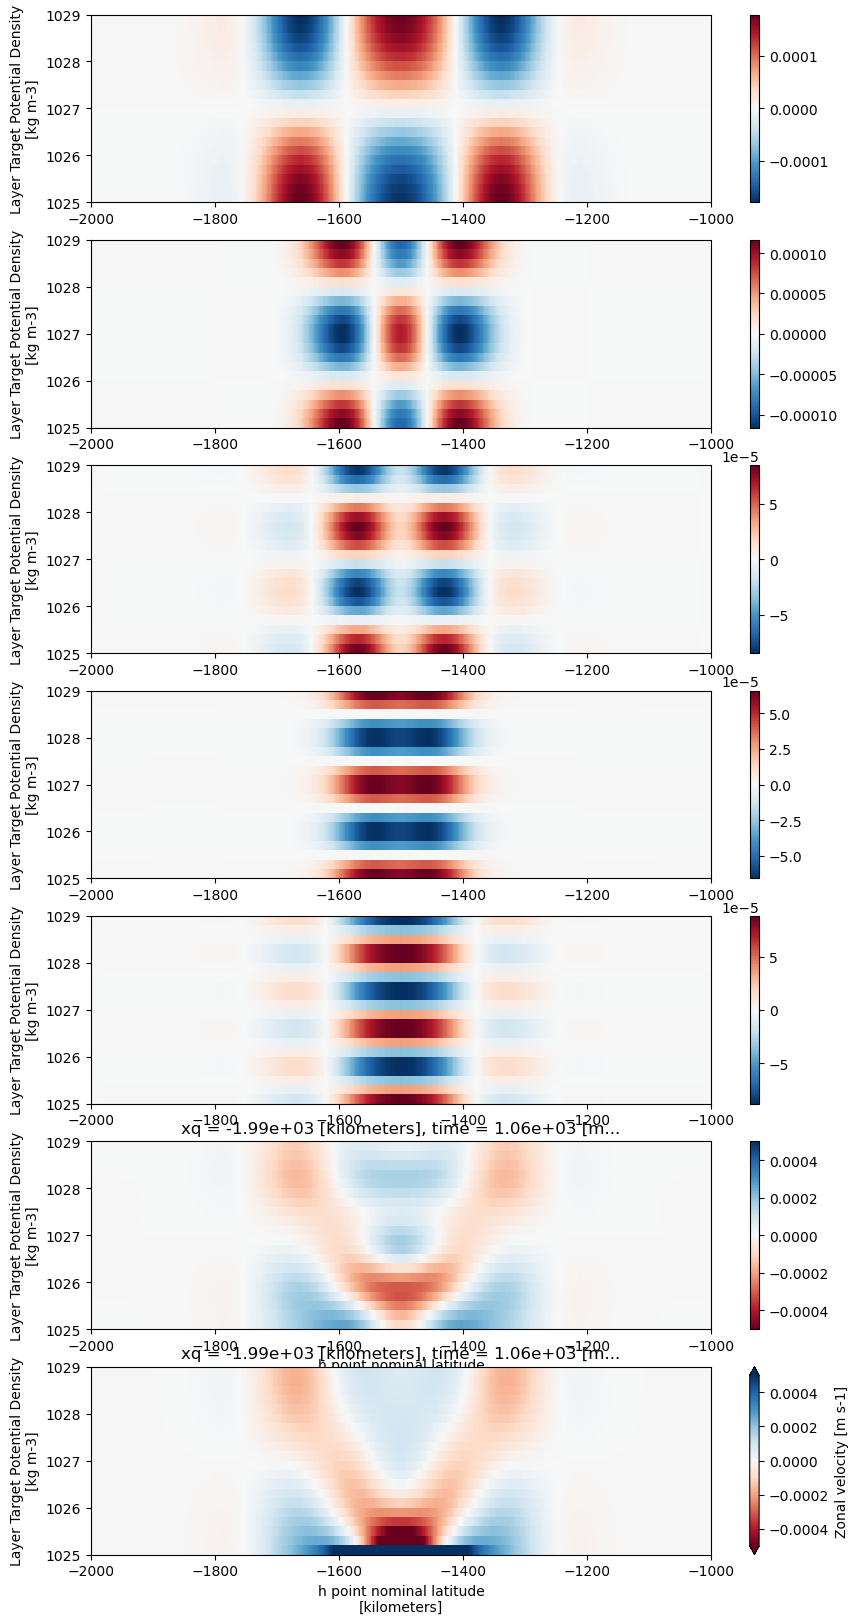

In [16]:
fig,ax = plt.subplots(7,1,figsize = (10,20))

for i in range(0,5):
    (u_modes.isel(mode = i) * phi.isel(mode = i)).isel(time = 5).plot(y = "zl",ax = ax[i])
    ax[i].set_title("")
    ax[i].set_xlabel("")
(u_modes * phi).isel(time = 5).sum("mode").plot(y = "zl",ax = ax[5],vmax = 0.0005,vmin = -0.0005,cmap = "RdBu")
(u).isel(time = 5).plot(y = "zl",ax = ax[6],vmax = 0.0005,vmin = -0.0005,cmap = "RdBu")

## Single function to retrieve modal energy integrated in depth

Calculate the 2D coefficients for u,v,w as timeseries. Don't need to return any vertical information!

In [2]:
import scipy
## Given e and u already sliced at a given time, regrid onto vertical coordinate

#todo Need to decide whether to write this for single point in space or all space

def ModalEnergy(data,nmodes = 5,N = np.sqrt((2 * 9.8) / (3275 * 1027))):
    """
    Data should be dataset with e,u,v and times still in hrs
    """
    data = data.assign_coords(time = data.time * 60) ## Convert to seconds
    zl = -1 * (data.e.isel(zi = range(0,20)).values + data.e.isel(zi = range(1,21))).values / 2
    zi = data.e
    if "xq" in data.dims:
        data["u"] = data.u.interp(xq = data.xh)
    if "yh" in data.dims:
        data["v"] = data.v.interp(yq = data.yh)

    w = data.e.differentiate("time").fillna(0)
    u_modes = xr.DataArray(
        np.zeros(data.u.isel(zl = 0).shape + (nmodes,)),
        dims = data.u.isel(zl = 0).dims + ('mode',),
        coords = data.u.isel(zl = 0).coords
    ).assign_coords(mode = np.arange(1,nmodes + 1)).rename("u")
    v_modes = u_modes.rename("v") * 0
    w_modes = xr.DataArray(
        np.zeros(w.isel(zi = 0).shape + (nmodes,)),
        dims = w.isel(zi = 0).dims + ('mode',),
        coords = w.isel(zi = 0).coords
    ).assign_coords(mode = np.arange(1,nmodes + 1)).rename("w")

    for n in range(1,nmodes + 1):
        phi_zl = np.sqrt(2/4000) * np.cos(zl * n * np.pi / 4000) ## Simple vertical modes with constant N
        phi_zi = np.sqrt(2/4000) * np.cos(zi * n * np.pi / 4000) ## Same but with zi vertical coord


        # print(phi_zi * w)

        v_modes.loc[{"mode":n}] = scipy.integrate.trapezoid(phi_zl * data.v,x = zl,axis = data.v.get_axis_num('zl'))
        u_modes.loc[{"mode":n}] = scipy.integrate.trapezoid(phi_zl * data.u,x = zl,axis = data.u.get_axis_num('zl'))
        w_modes.loc[{"mode":n}] = scipy.integrate.trapezoid(phi_zi * w,x = zi,axis = w.get_axis_num('zi'))
    # return scipy.integrate.trapezoid(phi_zl * data.v,x = zl,axis = data.v.get_axis_num('zl'))
    return xr.merge([u_modes,v_modes,w_modes])
# data = xr.merge([e,u,v]).load()
# # data = xr.merge([e - e.mean("xh"),u-u.mean("xq"),v-v.mean("xh")]).load()
# out = ModalEnergy(data)
# out = out.assign_coords(time = out.time / 60)

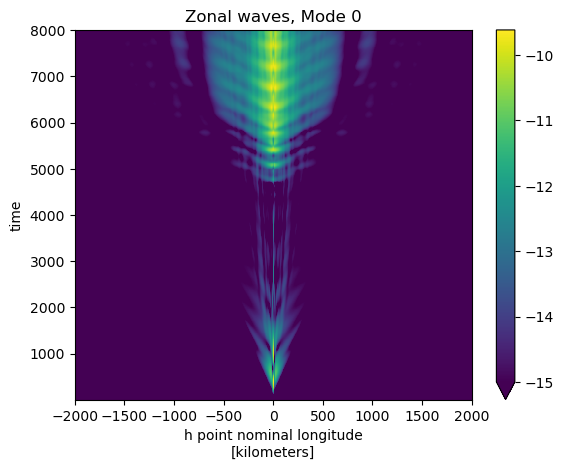

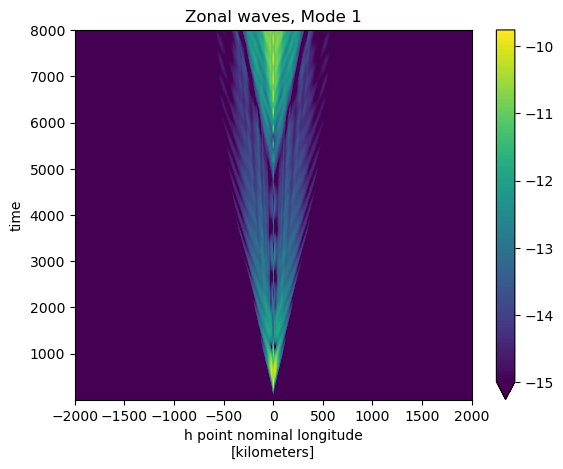

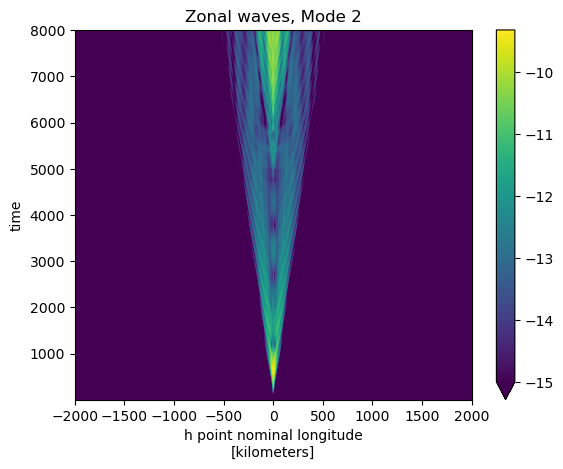

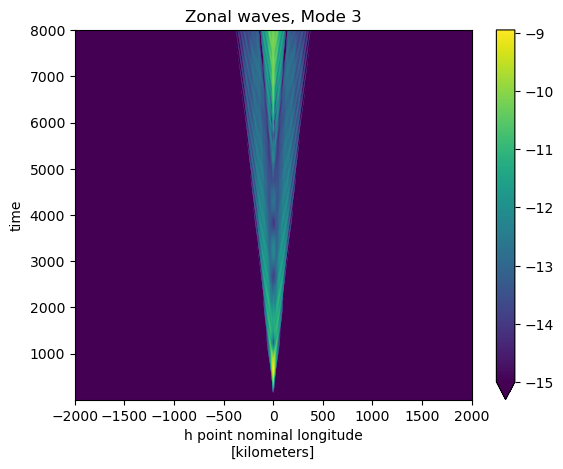

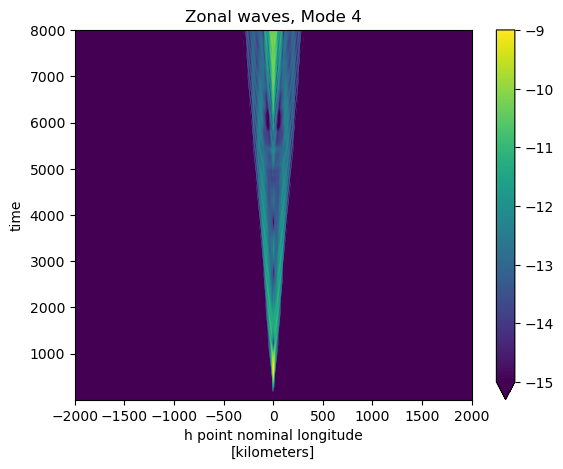

<Figure size 640x480 with 0 Axes>

In [79]:
## Run with orlanski tan. 

for i in range(5):
    # (out.u**2 + out.v**2 ).isel(mode = i,time = slice(24,1000)).sel(yh = slice(-1200,None)).plot()
    np.log((out.u - out.u.mean("xh"))**2 + (out.v - out.v.mean("xh"))**2 + (out.w - out.w.mean("xh"))**2).isel(mode = i,time = slice(0,800)).plot(vmin = -15)
    plt.title("Zonal waves, Mode " + str(i))

    # (out.v**2).isel(mode = i,time = slice(24,None)).plot()
    plt.figure()


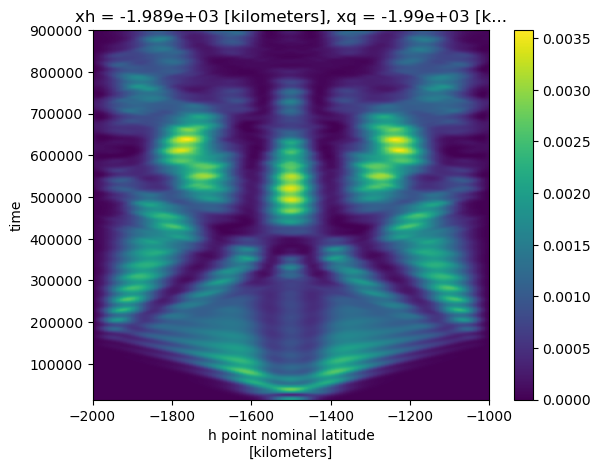

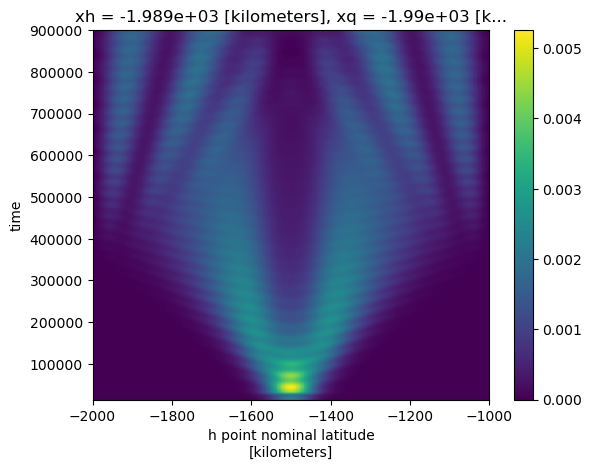

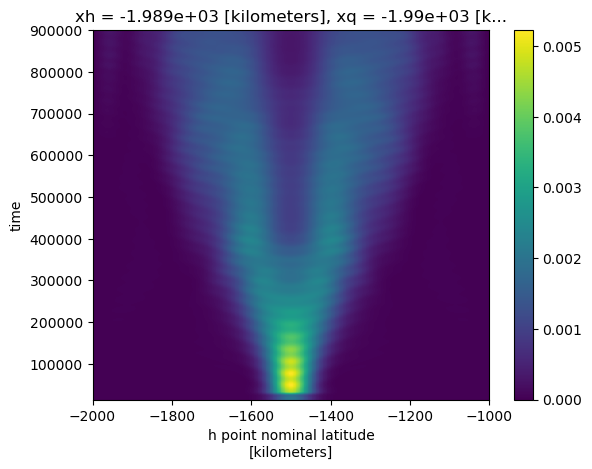

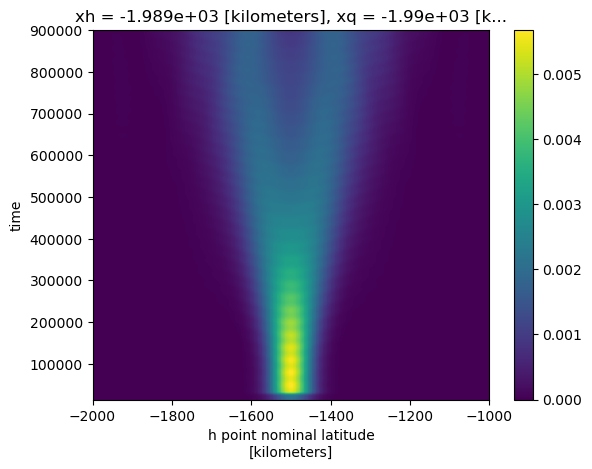

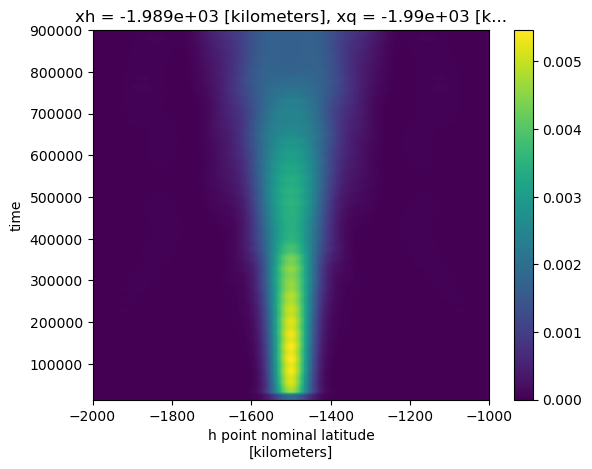

<Figure size 640x480 with 0 Axes>

In [5]:
## Run with orlanski tan. 

for i in range(5):
    # (out.u**2 + out.v**2 ).isel(mode = i,time = slice(24,1000)).sel(yh = slice(-1200,None)).plot()
    (out.u**2 + out.v**2 + out.w**2).isel(mode = i,time = slice(24,None)).plot()
    plt.figure()


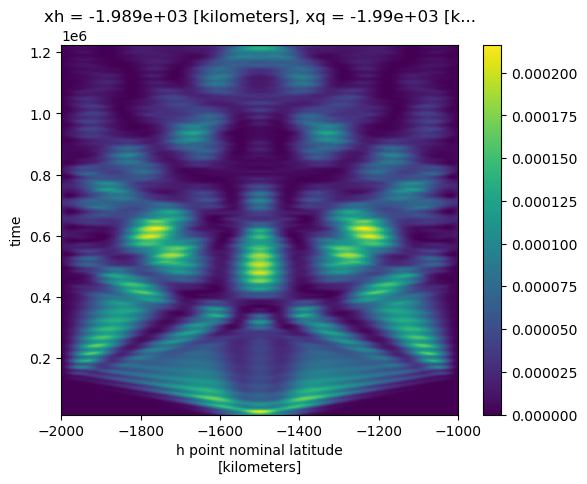

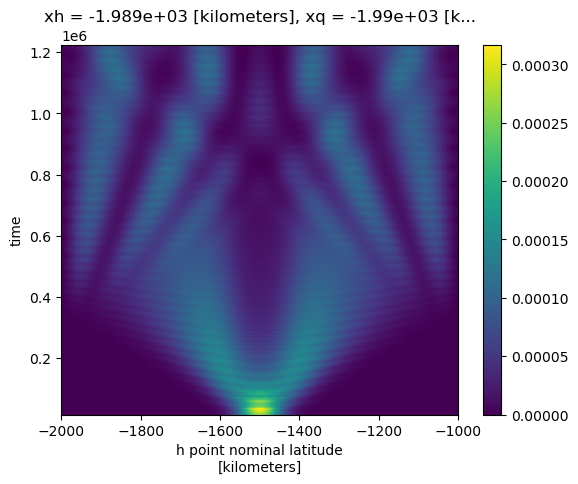

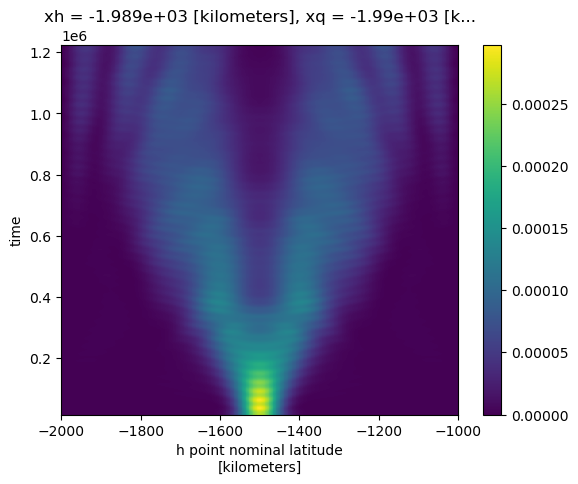

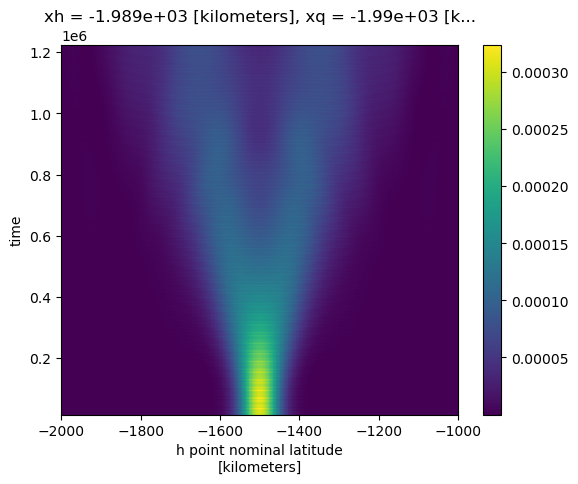

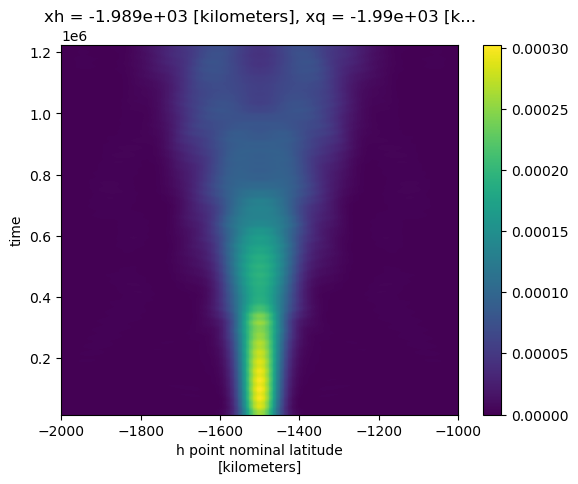

<Figure size 640x480 with 0 Axes>

In [161]:
for i in range(5):
    # (out.u**2 + out.v**2 ).isel(mode = i,time = slice(24,1000)).sel(yh = slice(-1200,None)).plot()
    (out.u**2 + out.v**2 + out.w**2).isel(mode = i,time = slice(24,None)).plot()
    plt.figure()


In [165]:
for i in range(5):
    # (out.u**2 + out.v**2 ).isel(mode = i,time = slice(24,1000)).sel(yh = slice(-1200,None)).plot()
    print(np.round((out.u**2 + out.v**2 + out.w**2).isel(mode = i).integrate("time").integrate("yh").values))

54111.0
57513.0
48629.0
42807.0
35753.0


## Make top down map of modes

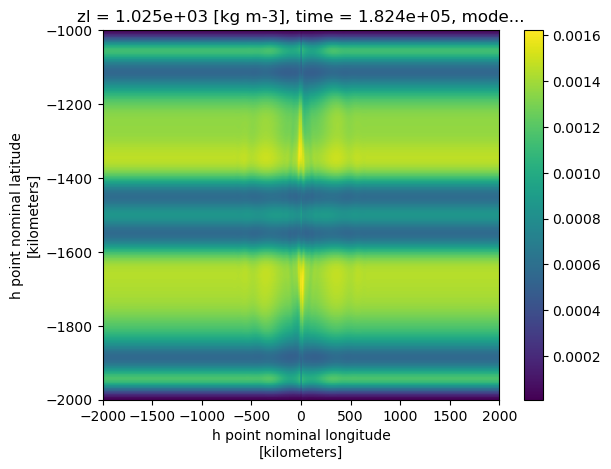

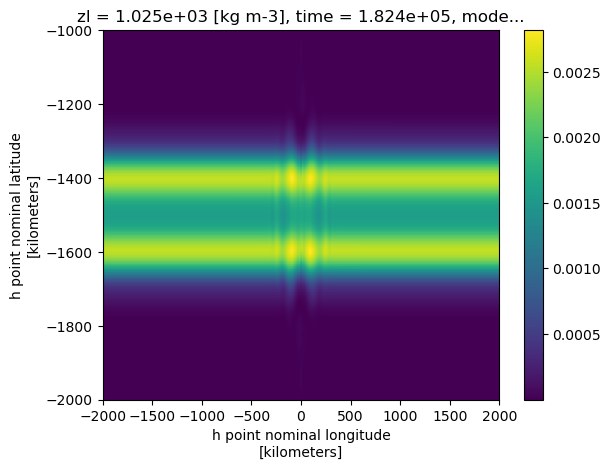

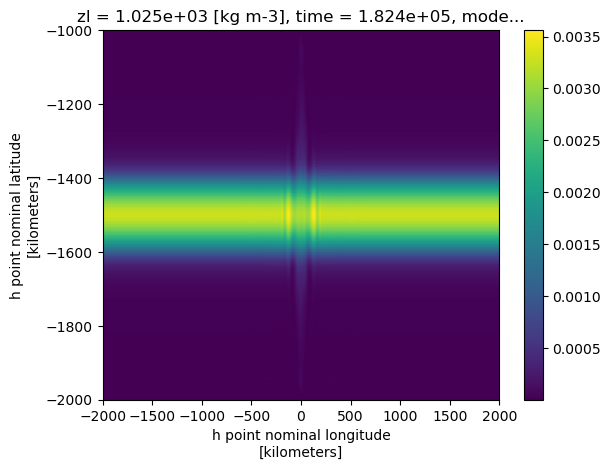

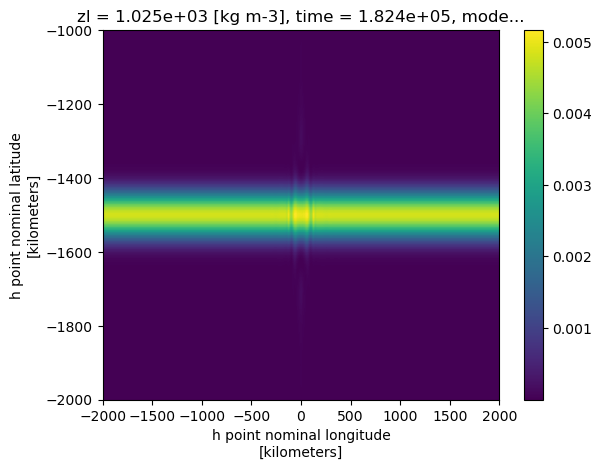

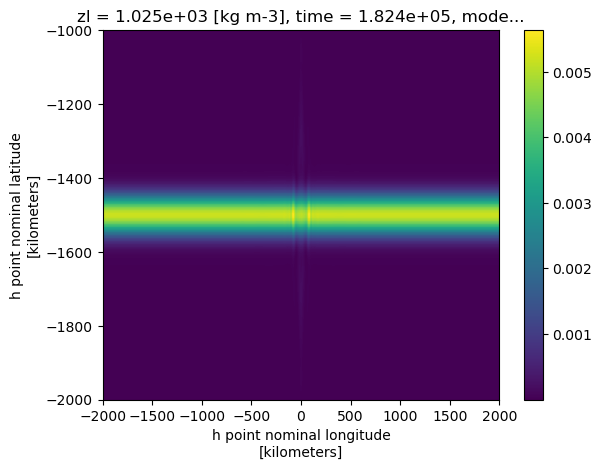

<Figure size 640x480 with 0 Axes>

In [67]:
basepath = "/home/149/ab8992/bottom_near_inertial_waves/revision/RemoveReflections"

e = xr.open_mfdataset(f"{basepath}/archive/output0*/e_10min.nc",decode_times = False).isel(time = slice(300,305)).e

u = xr.open_mfdataset(f"{basepath}/archive/output0*/u_10min.nc",decode_times = False).isel(time = slice(300,305)).u

v = xr.open_mfdataset(f"{basepath}/archive/output0*/v_10min.nc",decode_times = False).isel(time = slice(300,305)).v

data = xr.merge([e,u,v]).load()
# data = xr.merge([e - e.mean("xh"),u-u.mean("xq"),v-v.mean("xh")]).load()
out = ModalEnergy(data)

for i in range(5):
    # (out.u**2 + out.v**2 ).isel(mode = i,time = slice(24,1000)).sel(yh = slice(-1200,None)).plot()
    (out.u**2 + out.v**2 + out.w**2).isel(mode = i,time = 3).plot()
    plt.figure()

## Double the yextent to see if reflections cause zonal behaviour!

loading
loaded


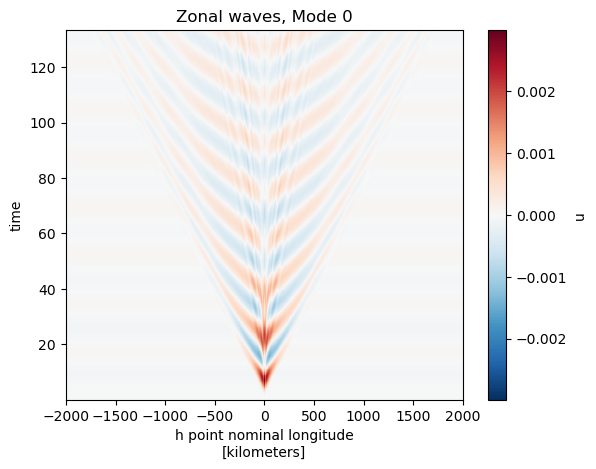

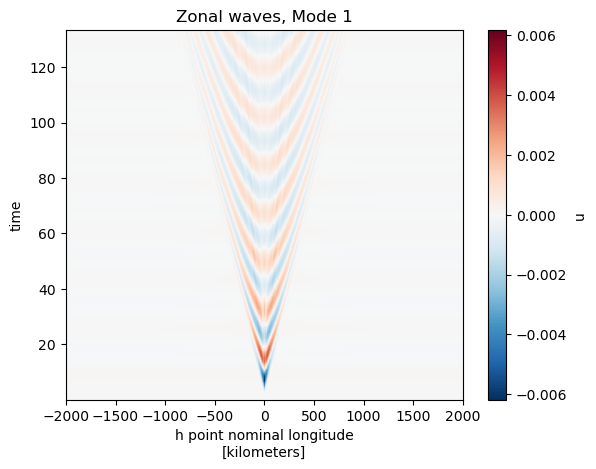

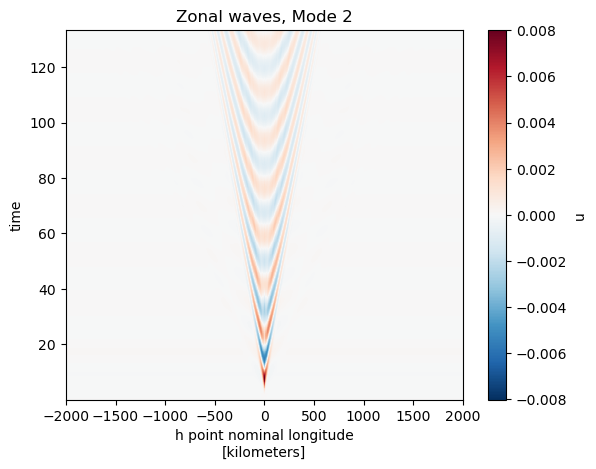

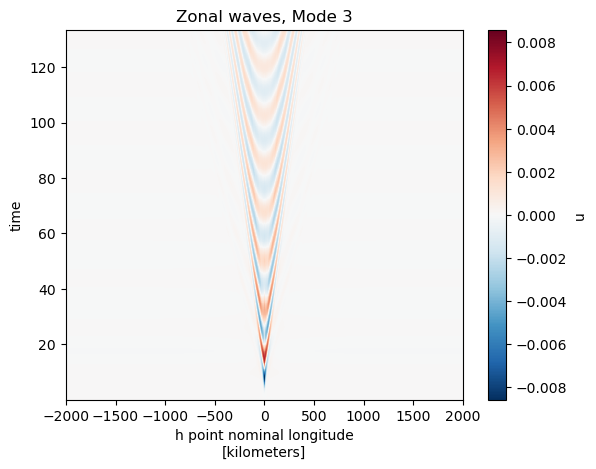

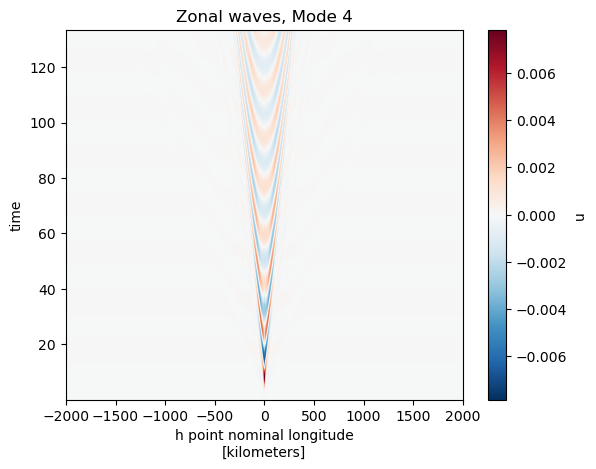

<Figure size 640x480 with 0 Axes>

In [14]:
basepath = "/home/149/ab8992/bottom_near_inertial_waves/revision/double_yextent"

e = xr.open_mfdataset(f"{basepath}/archive/output0*/e_10min.nc",decode_times = False).isel(yh = slice(500,501)).mean("yh").e
u = xr.open_mfdataset(f"{basepath}/archive/output0*/u_10min.nc",decode_times = False).isel(yh = slice(500,501)).mean("yh").u
v = xr.open_mfdataset(f"{basepath}/archive/output0*/v_10min.nc",decode_times = False).isel(yq = 500).v
print("loading")
# data_zonal = xr.merge([e,u,v]).load()
print("loaded")
# out = ModalEnergy(data_zonal)
# out = out.assign_coords(time = out.time / 60)
for i in range(5):
    # (out.u**2 + out.v**2 ).isel(mode = i,time = slice(24,1000)).sel(yh = slice(-1200,None)).plot()
    # np.log((out.u - out.u.mean("xh"))**2 + (out.v - out.v.mean("xh"))**2 + (out.w - out.w.mean("xh"))**2).isel(mode = i,time = slice(0,800)).plot(vmin = -15)
    (out.u - out.u.mean("xh")).isel(mode = i,time = slice(0,800)).plot()
    # np.log((out.u)**2 + (out.v)**2 + (out.w)**2).isel(mode = i,time = slice(0,None)).plot(vmin = -15)
    plt.title("Zonal waves, Mode " + str(i))
    # (out.v**2).isel(mode = i,time = slice(24,None)).plot()
    plt.figure()

loading
loaded


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


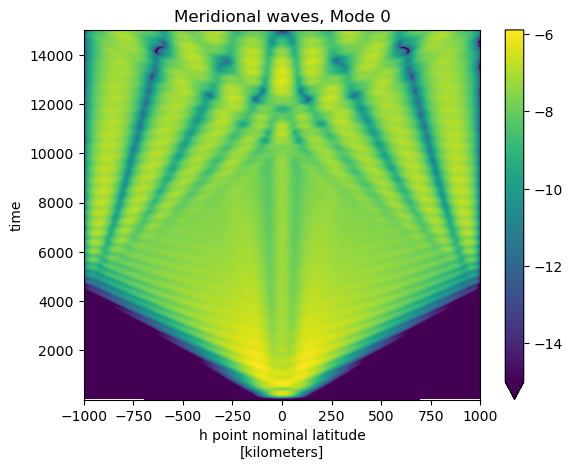

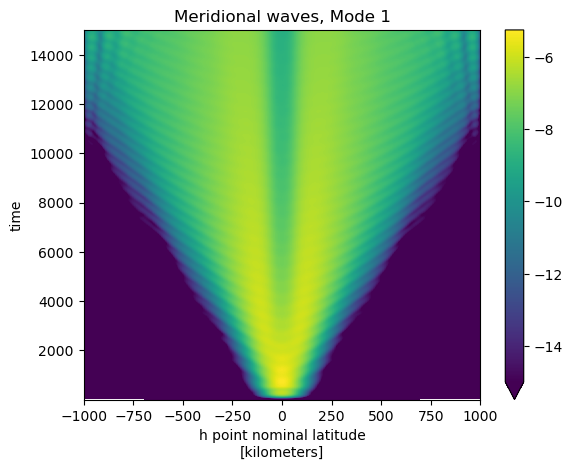

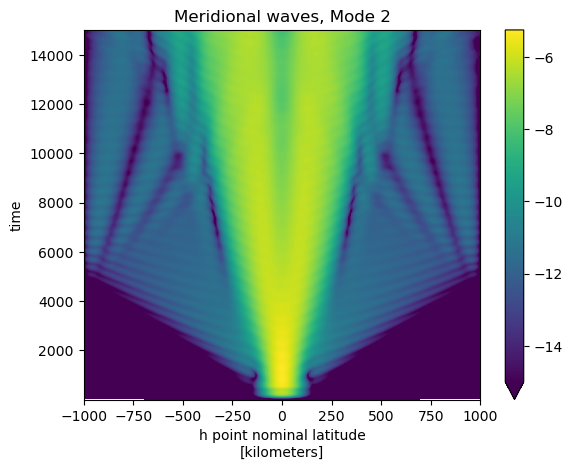

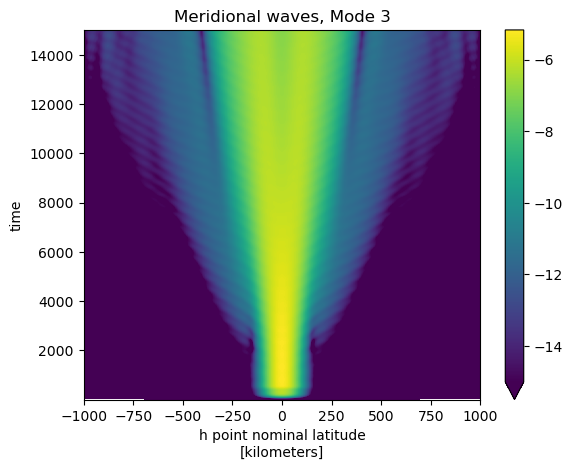

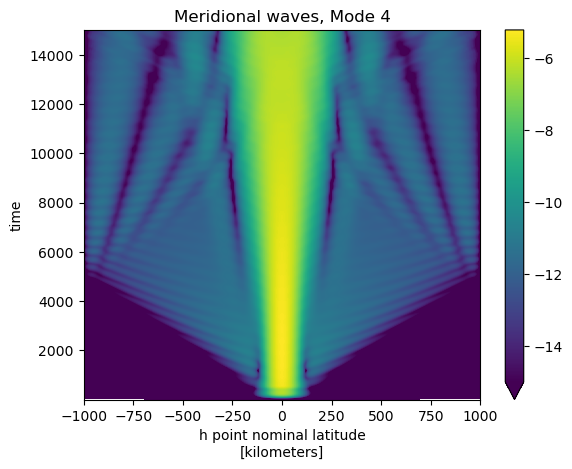

<Figure size 640x480 with 0 Axes>

In [9]:
basepath = "/home/149/ab8992/bottom_near_inertial_waves/revision/double_yextent"

e = xr.open_mfdataset(f"{basepath}/archive/output0*/e_10min.nc",decode_times = False).isel(xh = 5).e
u = xr.open_mfdataset(f"{basepath}/archive/output0*/u_10min.nc",decode_times = False).isel(xq = 5).u
v = xr.open_mfdataset(f"{basepath}/archive/output0*/v_10min.nc",decode_times = False).isel(xh = 5).v
print("loading")
# data_merid = xr.merge([e,u,v]).load()
print("loaded")
out = ModalEnergy(data_merid)
out = out.assign_coords(time = out.time / 60)
for i in range(5):
    # (out.u**2 + out.v**2 ).isel(mode = i,time = slice(24,1000)).sel(yh = slice(-1200,None)).plot()
    np.log((out.u)**2 + (out.v)**2 + (out.w)**2).isel(mode = i,time = slice(0,None)).plot(vmin = -15)
    plt.title("Meridional waves, Mode " + str(i))
    # (out.v**2).isel(mode = i,time = slice(24,None)).plot()
    plt.figure()